# Generating PSFs

This notebook demonstrates how to build a drizzle PSF using sample data included with *Mophongo*.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mophongo.psf import DrizzlePSF
from mophongo.templates import _convolve2d
from mophongo.utils import clean_stamp
import mophongo.utils as utils


## Load the drizzle image and WCS info

In [57]:
#filt = 'F770W'
#filter_regex = f'UDS_MIRI_{filt}_GRID1_OS4'
# for NIRCam you would use e.g. filt = 'F444W'
filt = 'F444W'
filter_regex = f'UDS_NRC.._{filt}_GRID1_OS4'
filter_regex = f'UDS_NRC.._{filt}_OS4'
#filt = 'F115W'
#filter_regex = f'UDS_NRC.._{filt}'
#filter_regex = f'STDPSF_NRC.._{filt}'
data_dir = Path('../data')
drz_file = data_dir / f'uds-test-{filt.lower()}_sci.fits'
csv_file = data_dir / f'uds-test-{filt.lower()}_wcs.csv'

psf_dir = data_dir / 'PSF'
dpsf = DrizzlePSF(driz_image=str(drz_file), csv_file=str(csv_file))
dpsf.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=filter_regex, verbose=True)


## Extract a PSF at a chosen position

In [54]:
filter_regex = f'UDS_NRC.._{filt}'
verbose = False
#ra, dec = 34.298227, -5.1262533
ra, dec = 34.30421, -5.1221624
size = 201
Rnorm_as = 1.5

cutout_reg = dpsf.get_driz_cutout(ra, dec, size=15, verbose=verbose, recenter=True)
pos_drz, _, _ = dpsf.register(cutout_reg, filter_regex, verbose=verbose)

cutout = dpsf.get_driz_cutout(ra, dec, size=size, verbose=verbose, recenter=True)
psf_data = dpsf.get_psf(
    ra=pos_drz[0], dec=pos_drz[1],
    filter=filter_regex, wcs_slice=cutout.wcs,
    kernel=dpsf.driz_header['KERNEL'], pixfrac=dpsf.driz_header['PIXFRAC'],
)

psf_data, obj, bg_level = clean_stamp(psf_data, verbose=verbose, imshow=False)
cutout_data, obj, bg_level = clean_stamp(cutout.data, verbose=verbose, imshow=verbose)


Position: [242.81932816 342.65688608], Filter: UDS_NRCA5_F444W, in frame: jw01837002005_08201_00001_nrcalong_rate.fits[SCI,1]
Position: [268.99070724 351.15188592], Filter: UDS_NRCA5_F444W, in frame: jw01837002005_08201_00002_nrcalong_rate.fits[SCI,1]
Position: [1408.12146182  453.28841838], Filter: UDS_NRCA5_F444W, in frame: jw01837034001_09201_00001_nrcalong_rate.fits[SCI,1]
Position: [1434.40772365  461.61200686], Filter: UDS_NRCA5_F444W, in frame: jw01837034001_09201_00002_nrcalong_rate.fits[SCI,1]
Position: [ 171.84174319 1857.39993834], Filter: UDS_NRCB5_F444W, in frame: jw03990064001_05201_00001_nrcblong_rate.fits[SCI,1]
Position: [ 166.27341333 1851.00166643], Filter: UDS_NRCB5_F444W, in frame: jw03990064001_05201_00002_nrcblong_rate.fits[SCI,1]
Position: [ 177.33199354 1863.78438953], Filter: UDS_NRCB5_F444W, in frame: jw03990064001_05201_00003_nrcblong_rate.fits[SCI,1]
Position: [1631.30156223 1106.02543674], Filter: UDS_NRCA5_F444W, in frame: jw06480013001_03104_00001_nrcalo

## Match the PSF to the image and compare

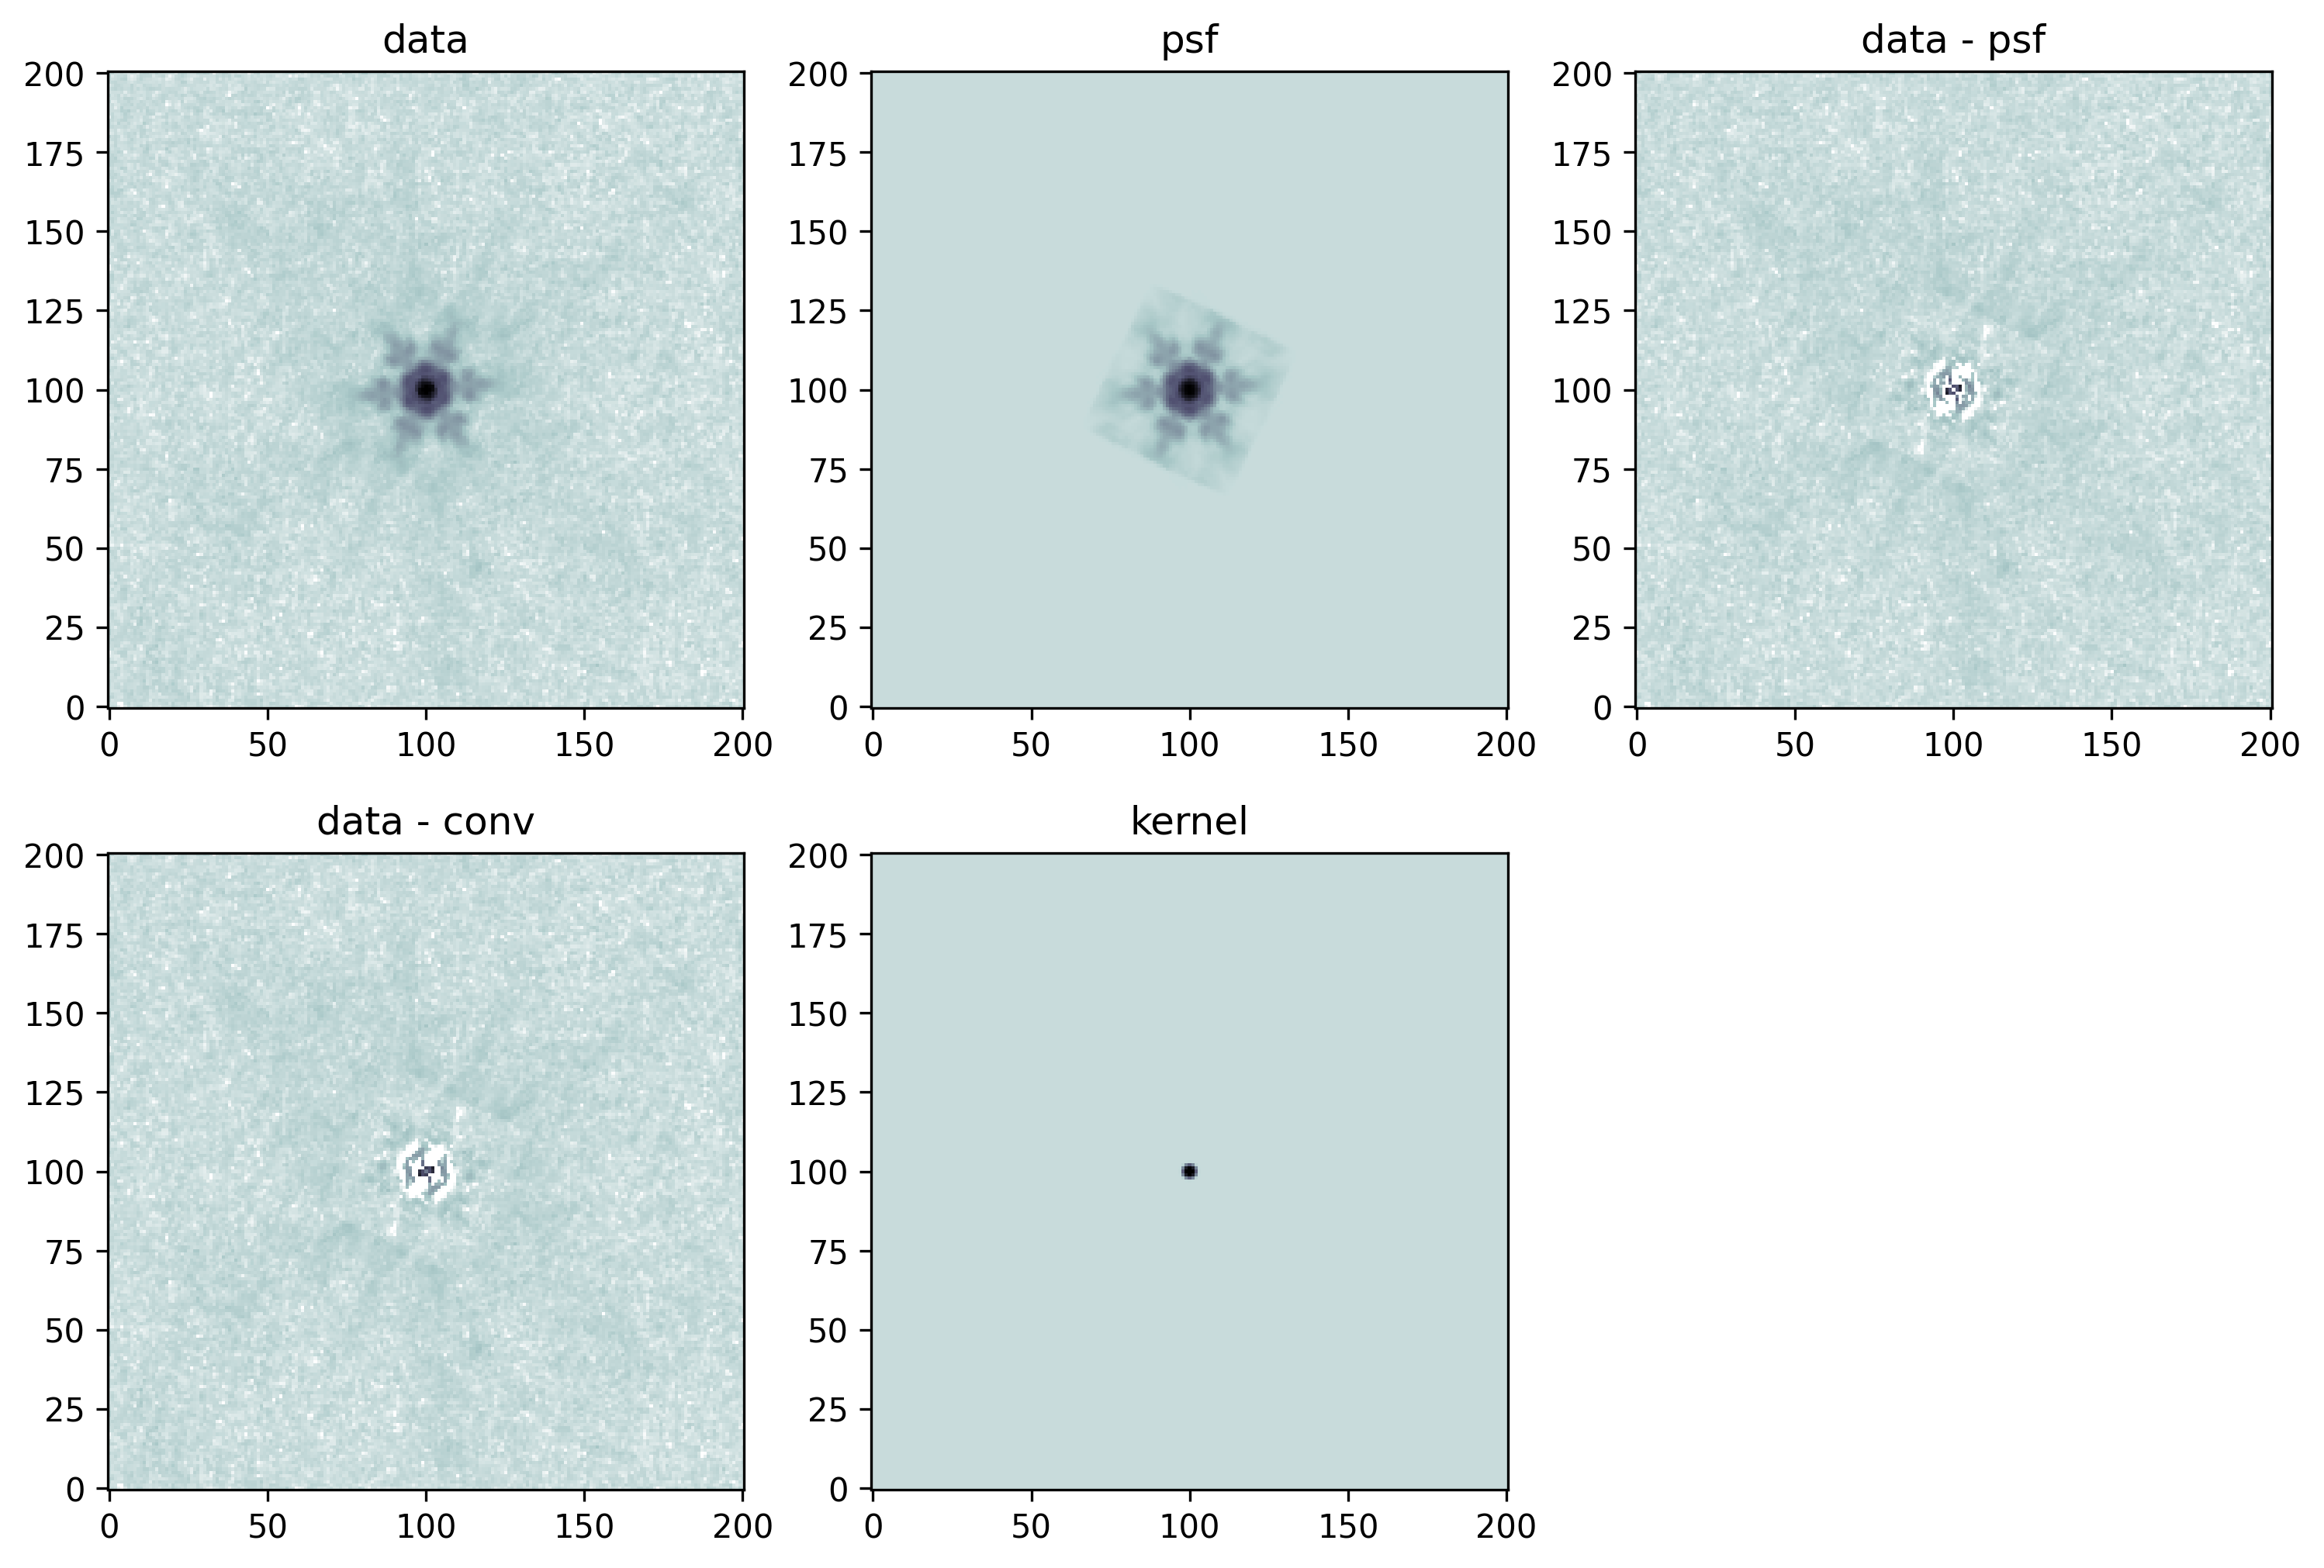

(<Figure size 4500x1200 with 3 Axes>,
 array([<Axes: xlabel='Radius (pix)', ylabel='Normalized Profile'>,
        <Axes: xlabel='Radius (pix)', ylabel='Encircled Energy'>,
        <Axes: xlabel='Radius (pix)', ylabel='COG Ratio'>], dtype=object))

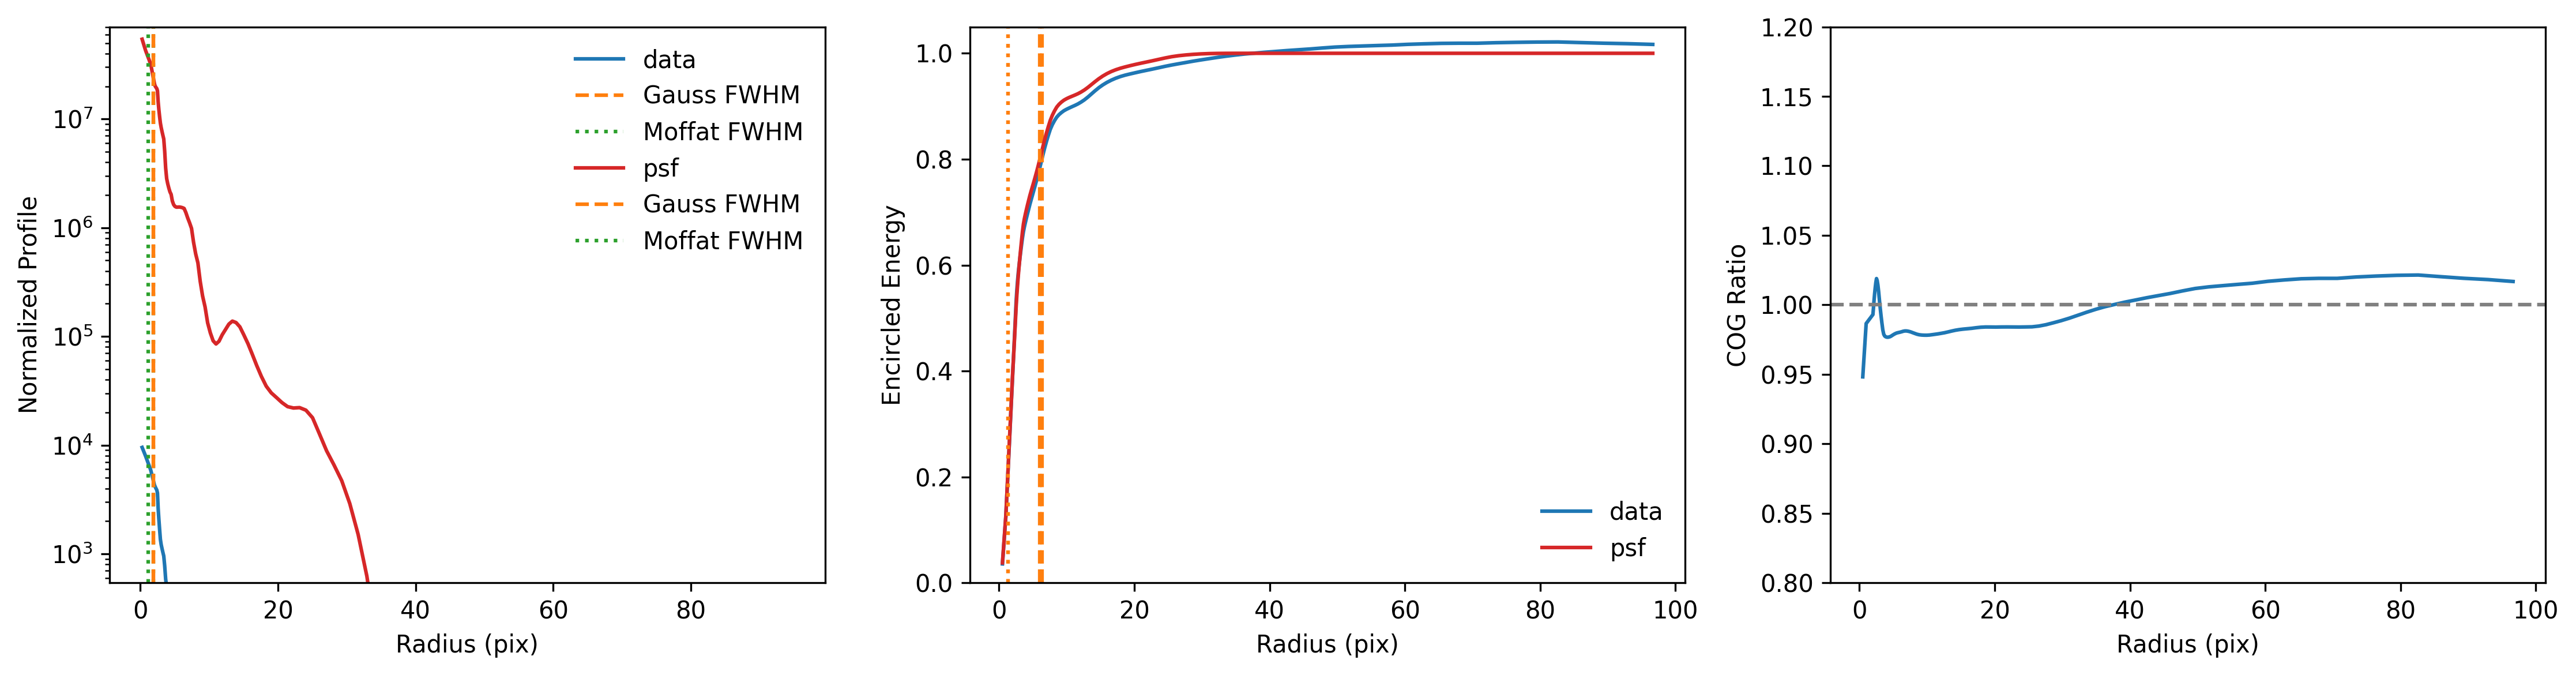

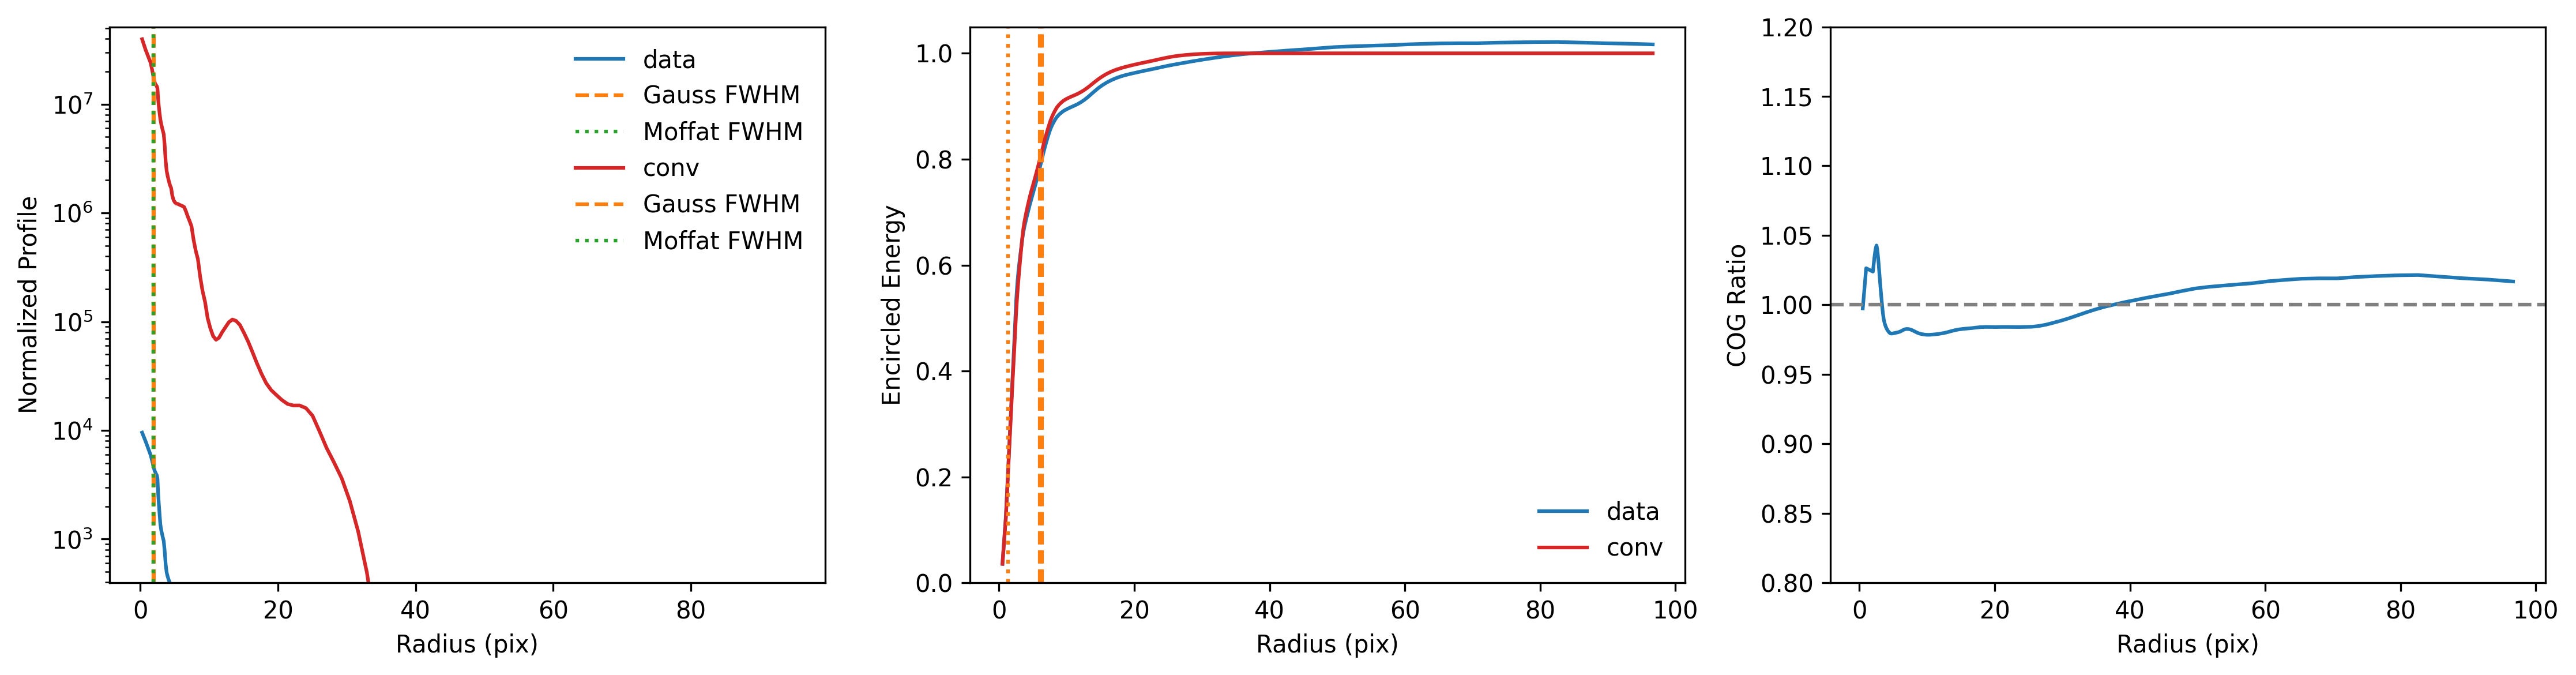

In [52]:
mask = np.hypot(*np.indices(cutout_data.shape) - cutout_data.shape[0]//2) < (Rnorm_as / dpsf.driz_pscale)
scl = (cutout_data * psf_data)[mask].sum() / (psf_data[mask]**2).sum()

recenter=True
rp_data = utils.CircularApertureProfile(cutout_data, name='data', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=recenter)
rp_psf = utils.CircularApertureProfile(psf_data, name='psf', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=recenter)

basis = utils.multi_gaussian_basis([0.5, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0], cutout_data.shape[0])
kernel, coeffs = utils.fit_kernel_fourier(psf_data, cutout_data, basis, method="nnls")
conv = _convolve2d(psf_data, kernel)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
offset = 2e-5
titles = ['data', 'psf', 'data - psf', 'data - conv', 'kernel']
kws = dict(vmin=-5.3, vmax=-1.5, cmap='bone_r', origin='lower')
axes[0].imshow(np.log10(cutout_data/scl + offset), **kws)
axes[1].imshow(np.log10(psf_data + offset), **kws)
axes[2].imshow(np.log10(cutout_data/scl - psf_data + offset), **kws)
axes[3].imshow(np.log10(cutout_data/scl - conv + offset), **kws)
axes[4].imshow(np.log10(kernel + offset), **kws)
axes[5].axis('off')
for i in range(len(titles)):
    axes[i].set_title(titles[i])
plt.show()

rp_conv = utils.CircularApertureProfile(conv, name='conv', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=recenter)
rp_data.plot(compare_to=rp_psf)
rp_data.plot(compare_to=rp_conv)



In [26]:
i=1
#_=plt.imshow(basis.T[i])
basis.T[i].min(),basis.T[i].max() 

(np.float64(0.0), np.float64(0.3917201512933901))

In [18]:
dpsf.epsf_obj.epsf

OrderedDict([('UDS_MIRI_F770W_GRID1',
              array([[[1.0481757e-06],
                      [1.2702034e-06],
                      [1.2958200e-06],
                      ...,
                      [1.7522893e-06],
                      [1.6673411e-06],
                      [1.1485415e-06]],
              
                     [[1.3741275e-06],
                      [1.6880200e-06],
                      [1.7366290e-06],
                      ...,
                      [2.5369218e-06],
                      [2.1924275e-06],
                      [1.4711221e-06]],
              
                     [[1.5894303e-06],
                      [1.8914393e-06],
                      [1.9635579e-06],
                      ...,
                      [2.6034097e-06],
                      [2.1209630e-06],
                      [1.6666903e-06]],
              
                     ...,
              
                     [[2.1337503e-06],
                      [2.2023592e-06],
            

In [27]:
epsf = dpsf.epsf_obj.epsf['UDS_MIRI_F770W_GRID1']
epsf.shape[2]

1

In [ ]:
dates = [dpsf.hdrs[k]['MJD-AVG'] for k in dpsf.flt_keys]


In [21]:
du = dpsf.epsf_obj.epsf['UDS_MIRI_F770W']
#de = dpsf.epsf_obj.epsf['STDPSF_MIRI_F770W_EXTENDED']

In [1]:
cutout = dpsf.get_driz_cutout(ra, dec, size=size, verbose=True, recenter=True)

psf_data = dpsf.get_psf(
    ra=ra, dec=dec,
    filter=filter_regex, wcs_slice=cutout.wcs,
    kernel=dpsf.driz_header['KERNEL'], pixfrac=dpsf.driz_header['PIXFRAC'],
)
plt.imshow(psf_data)

NameError: name 'dpsf' is not defined

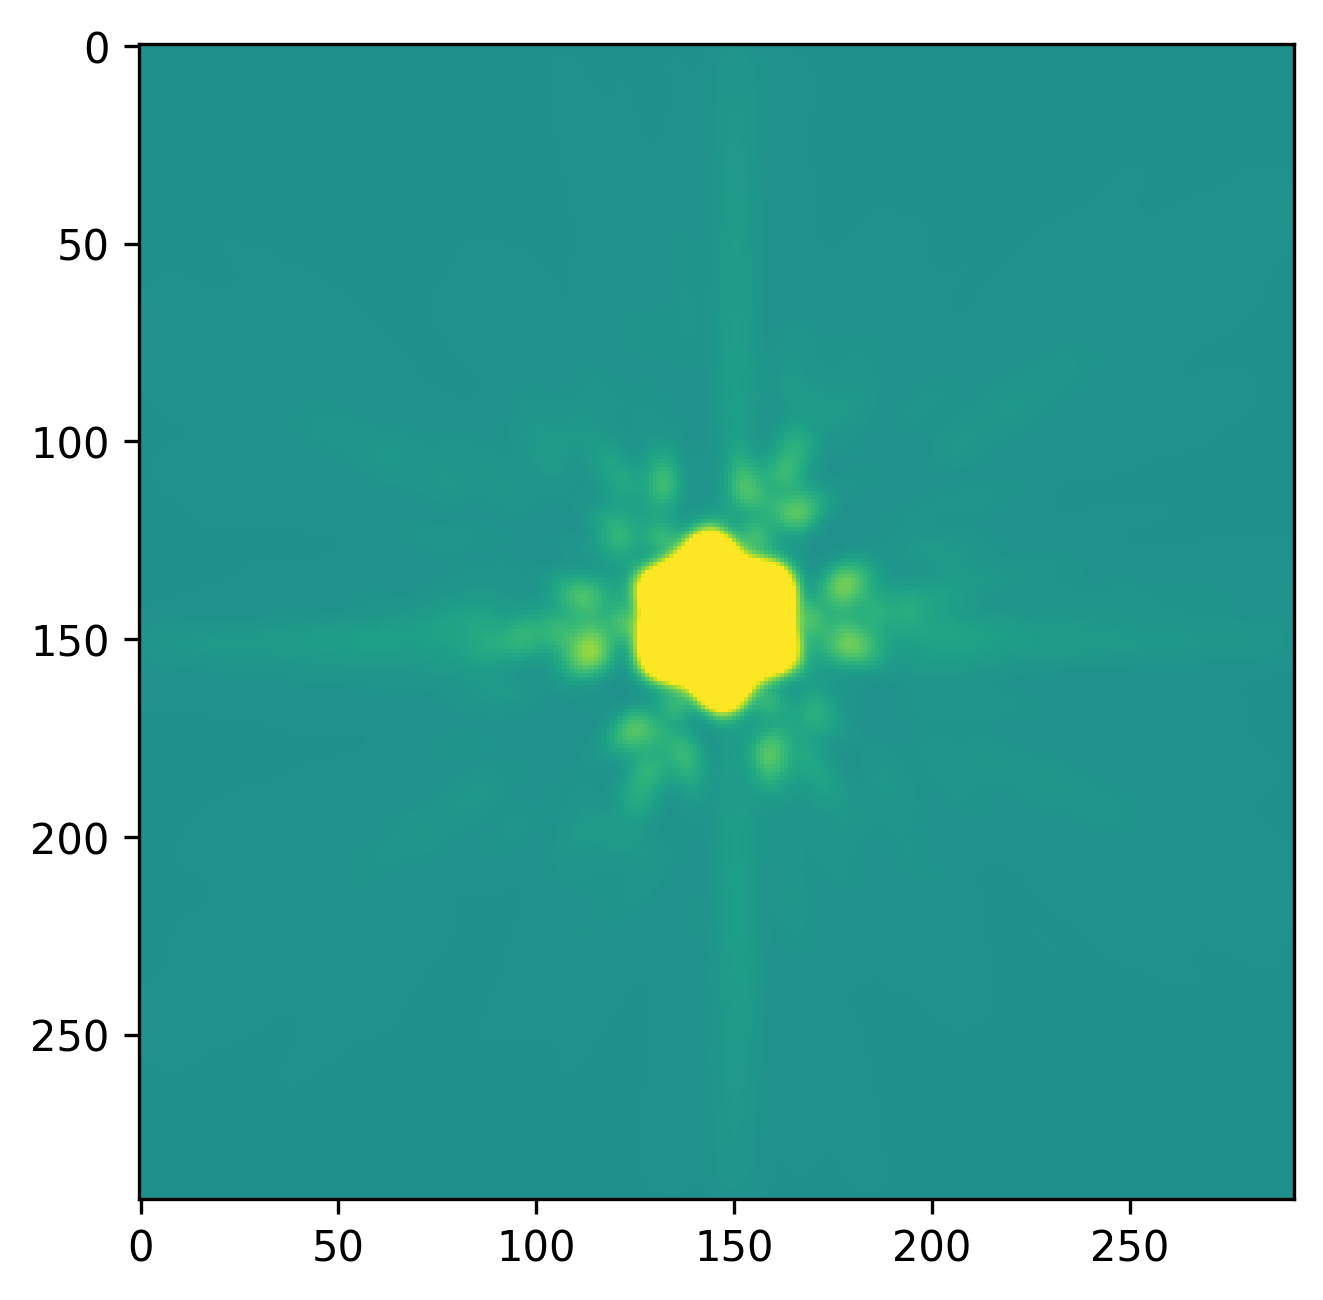

In [37]:
plt.imshow(dpsf.epsf_obj.get_at_position(-100,1,filter='UDS_MIRI_F770W'),vmin=-0.001,vmax=0.001)

In [ ]:
dpsf.epsf_obj.epsf_obj.eval_ePSF

AttributeError: 'EffectivePSF' object has no attribute 'epsf_obj'

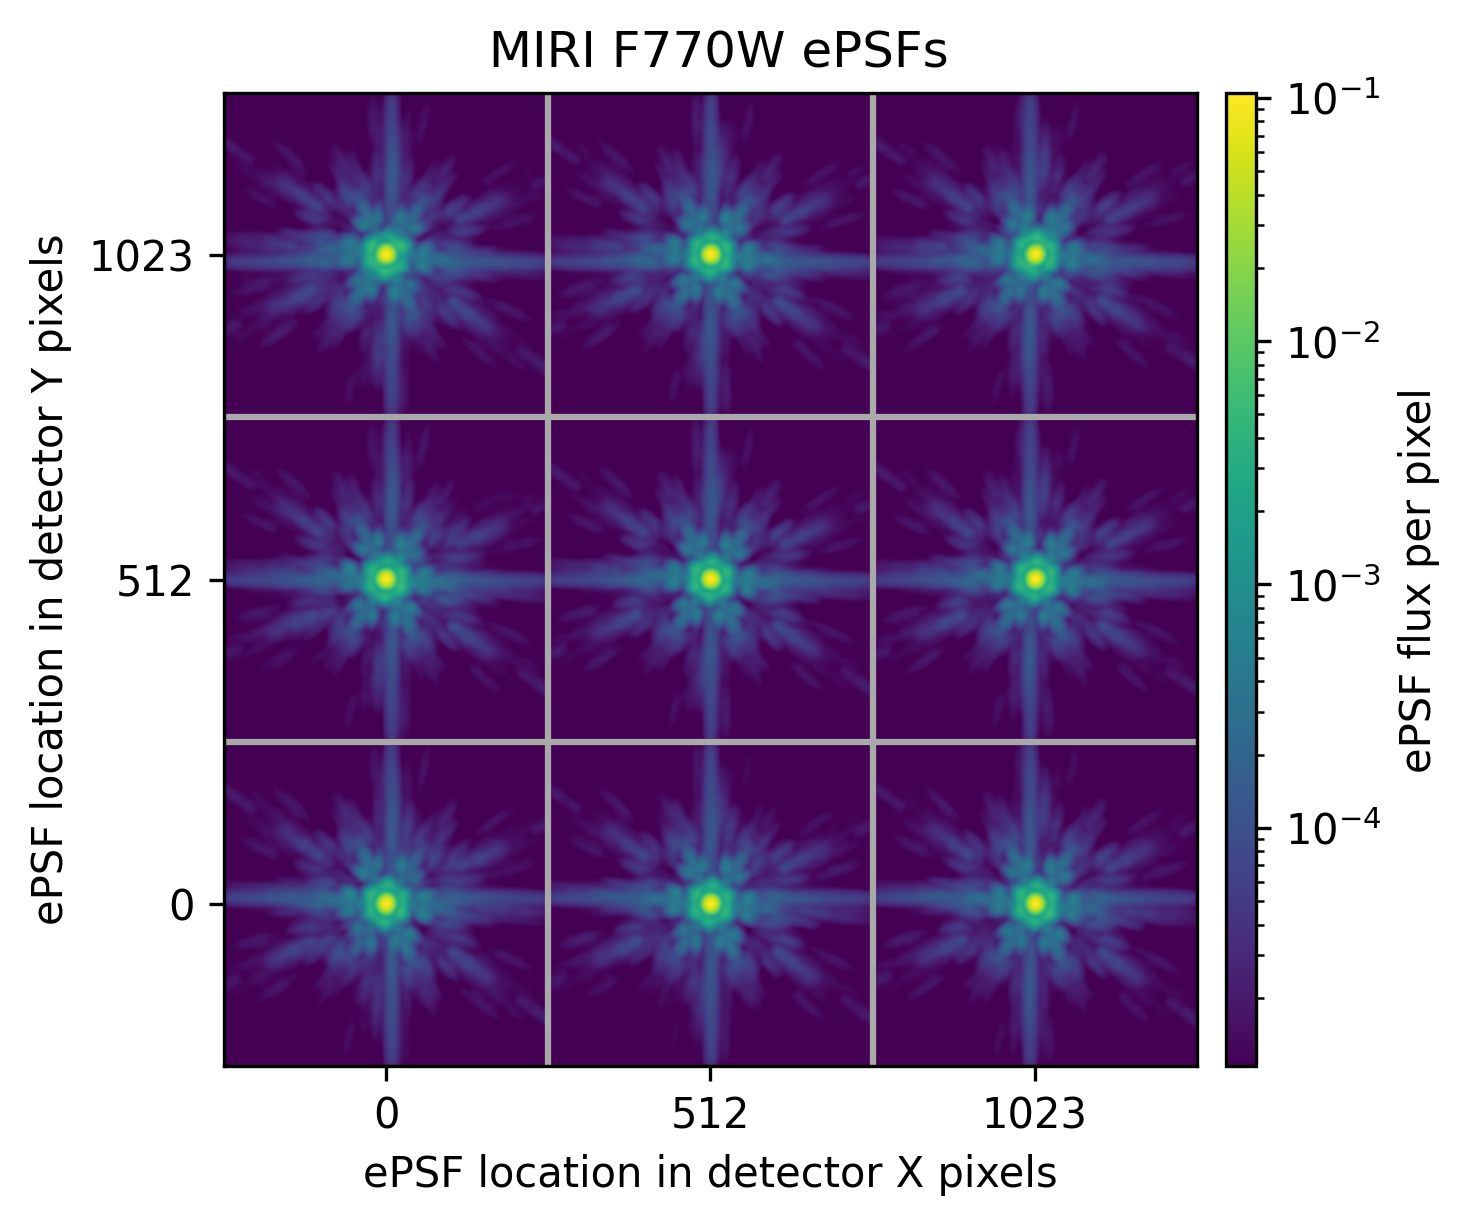

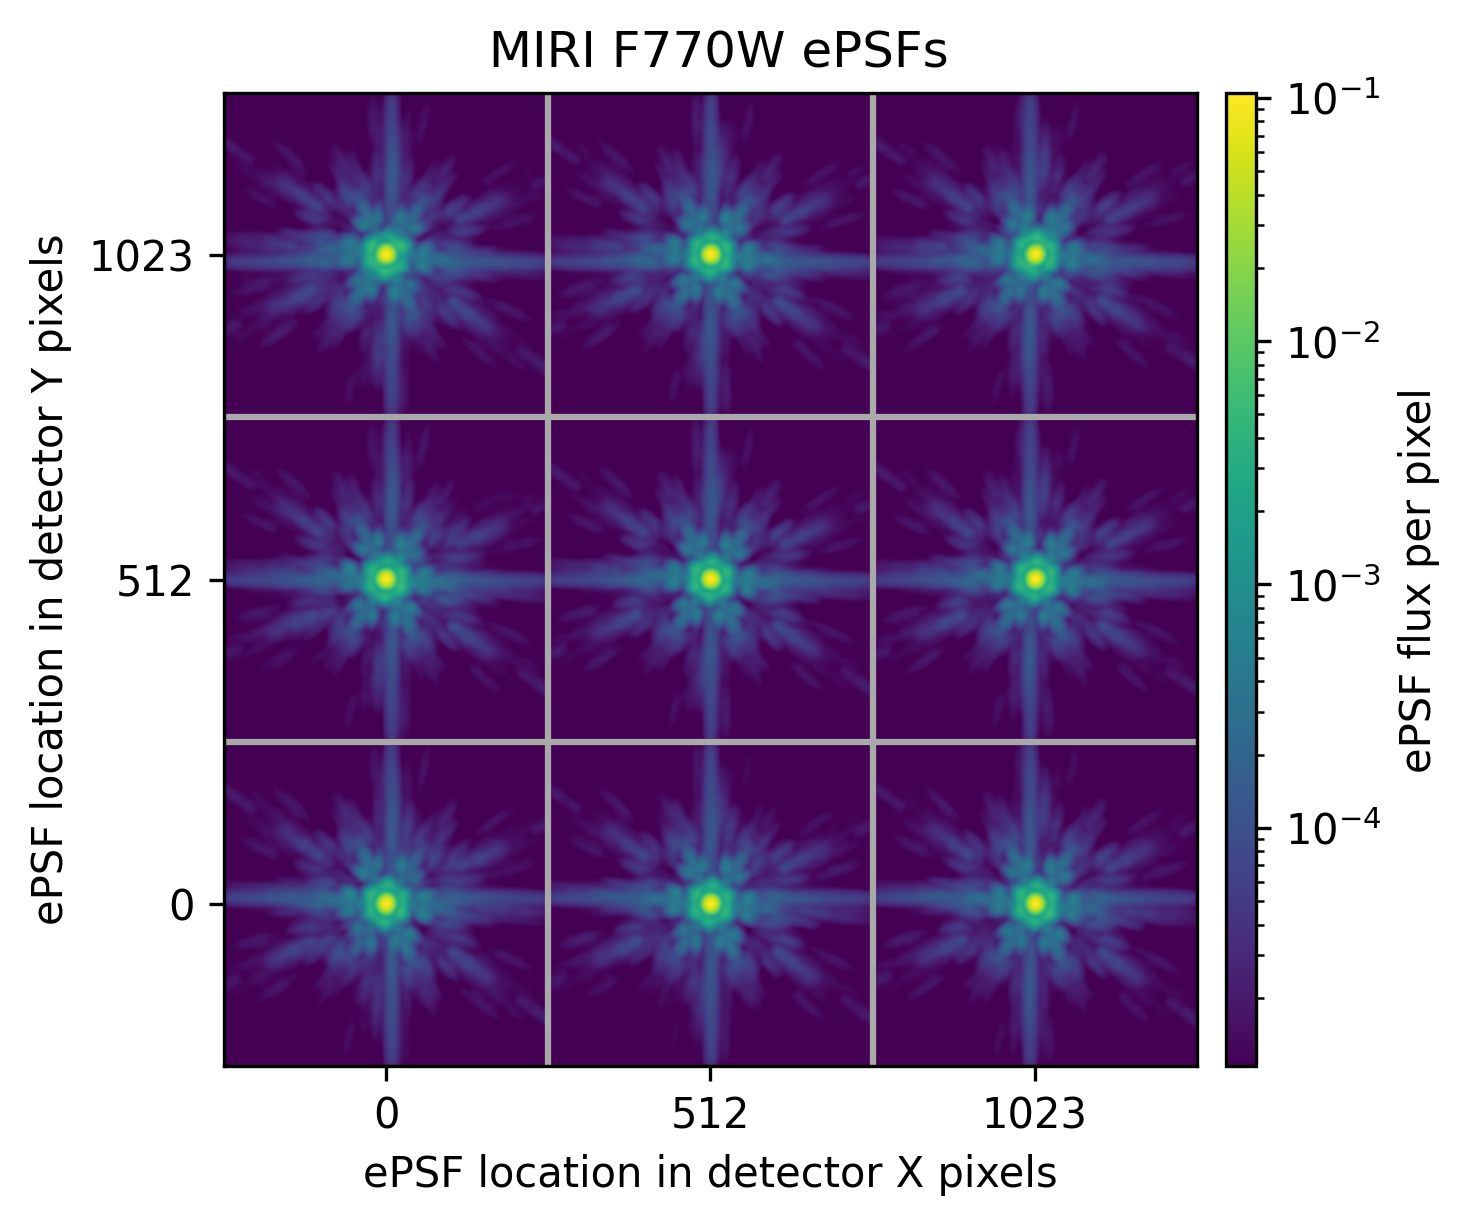

In [32]:
import photutils
#gg = photutils.psf.stdpsf_reader('../data/PSF/STDPSF_MIRI_F770W_EXTENDED.fits')
ggn = photutils.psf.stdpsf_reader('../data/PSF/UDS_MIRI_F770W.fits')
ggn.plot_grid()

In [31]:
ggn.grid_xypos

array([[   0,    0],
       [ 512,    0],
       [1023,    0],
       [   0,  512],
       [ 512,  512],
       [1023,  512],
       [   0, 1023],
       [ 512, 1023],
       [1023, 1023]])

In [17]:
ggn.bounding_box

ModelBoundingBox(
    intervals={
        x: Interval(lower=-36.5, upper=36.5)
        y: Interval(lower=-36.5, upper=36.5)
    }
    model=GriddedPSFModel(inputs=('x', 'y'))
    order='C'
)